In [4]:
import sys, os
import read_lif
import matplotlib.pylab as plt
import matplotlib as mpl
import numpy as np
import readlif

# Load `.lif` files

In [5]:
filename = os.path.join('data', '240228_#313.lif')

reader = read_lif.Reader(filename)
headers = reader.getSeriesHeaders()
series = reader.getSeries()

iSerie = 0
#print(dir(headers[iSerie]))

# dimensions
dims = headers[iSerie].getDimensions()
DIMS = []
for dim in dims:
    d0 = float(dim.getAttribute('Origin'))
    length = float(dim.getAttribute('Length'))
    N = int(dim.getAttribute('NumberOfElements'))
    DIMS.append(1e6*np.linspace(d0, d0+length, N)) # in um

X, Y, Z = np.meshgrid(*DIMS, indexing='ij')

# Series 004, 24/02/28 #313 --> series[2].getFrame(channel=1)
# channel 0 -> TdTomato
# channel 1 -> GFP
TdTomato_img = series[iSerie].getFrame(channel=0, dtype=np.uint16) # NEED TO RESHAPE HERE
GFP_img = series[iSerie].getFrame(channel=1, dtype=np.uint16)

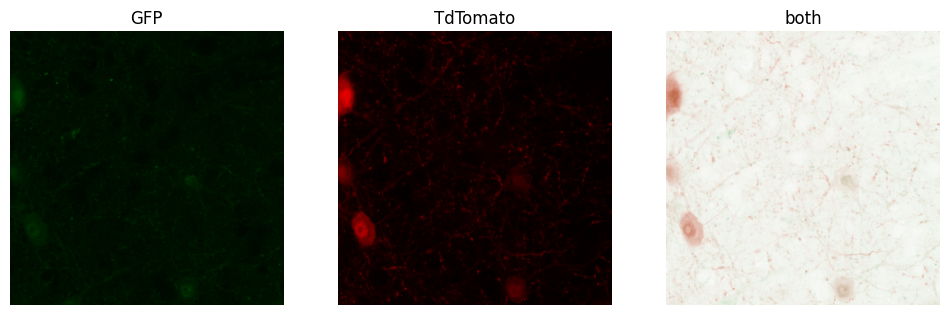

In [6]:
fig, AX = plt.subplots(1,3, figsize=(12,8))
plane = 0
def norm_img(img, exp=0.7):
    return np.power((img-img.min())/(img.max()-img.min()+1e-3), exp)
    
AX[0].imshow(norm_img(GFP_img[plane,:,:]), cmap=mpl.colors.LinearSegmentedColormap.from_list('mycolors', ['k', 'g']))
AX[1].imshow(norm_img(TdTomato_img[plane,:,:]), cmap=mpl.colors.LinearSegmentedColormap.from_list('mycolors', ['k', 'r']))
AX[2].imshow(norm_img(GFP_img[plane,:,:]), cmap=mpl.colors.LinearSegmentedColormap.from_list('mycolors', ['w', 'g']))
AX[2].imshow(norm_img(TdTomato_img[plane,:,:]), cmap=mpl.colors.LinearSegmentedColormap.from_list('mycolors', ['w', 'r']), alpha=.5)
for ax, title in zip(AX, ['GFP', 'TdTomato', 'both']):
    ax.axis('off')
    ax.set_title(title)

# Extract ROIs manually drawn from ImageJ

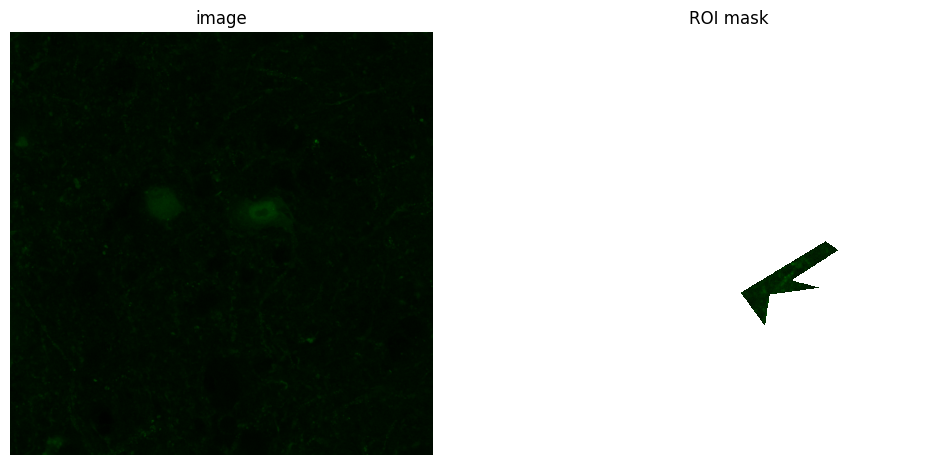

In [21]:
from roifile import roiread
from skimage.draw import polygon2mask

rois = roiread('data/RoiSet.zip')

roi = rois[1]

fig, AX = plt.subplots(1, 2, figsize=(12,8))

new_img = norm_img(GFP_img[roi.z_position,:,:])
AX[0].imshow(new_img, cmap=mpl.colors.LinearSegmentedColormap.from_list('mycolors', ['k', 'g']))

# mask outside of ROI
def build_mask(roi, shape):
    X, Y = roi.integer_coordinates.T
    X += roi.left
    Y += roi.top
    
    return polygon2mask(new_img.shape, [(x,y) for x,y in zip(Y,X)])

mask = build_mask(roi, new_img.shape)
new_img[~mask] = np.inf
AX[1].imshow(new_img, cmap=mpl.colors.LinearSegmentedColormap.from_list('mycolors', ['k', 'g']))

for ax, title in zip(AX, ['image', 'ROI mask']):
    ax.axis('off')
    ax.set_title(title)